In [42]:
# Import packages
import os
import sys
import numpy as np
import pandas as pd
import scanpy as sc
import decoupler as dc
import snapatac2 as snap
import scipy.stats as stats
sc.settings.verbosity = 0

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Set sc verbosity
sc.settings.verbosity = 0

%matplotlib inline

In [43]:
sys.path.append("/cellar/users/aklie/projects/igvf/single_cell_utilities")
from cell_type_annotation.utils import check_marker_genes
from plot.covariates import pretty_umap

# `rna`

In [44]:
# Paths
path_sc_islet = "/cellar/users/aklie/projects/igvf/islet_inflammatory_stress/results/1_sc-islet_integration/sc-islet/rna/sc-islet.h5ad"
path_primary_islet = "/cellar/users/aklie/data/datasets/islet_10X-Multiome/results/4_integration/rna/annotate/annotated.h5ad"
path_out = "/cellar/users/aklie/projects/igvf/islet_inflammatory_stress/results/1_sc-islet_integration/merged/rna"

# Make output directory
if not os.path.exists(path_out):
    os.makedirs(path_out)

## Load data

In [45]:
# Load sc-islet
adata_sc_islet = sc.read_h5ad(path_sc_islet)
adata_sc_islet

AnnData object with n_obs × n_vars = 87028 × 36601
    obs: 'gex_barcode_cellranger', 'atac_barcode_cellranger', 'is_cell_cellranger', 'excluded_reason_cellranger', 'gex_raw_reads_cellranger', 'gex_mapped_reads_cellranger', 'gex_conf_intergenic_reads_cellranger', 'gex_conf_exonic_reads_cellranger', 'gex_conf_intronic_reads_cellranger', 'gex_conf_exonic_unique_reads_cellranger', 'gex_conf_exonic_antisense_reads_cellranger', 'gex_conf_exonic_dup_reads_cellranger', 'gex_exonic_umis_cellranger', 'gex_conf_intronic_unique_reads_cellranger', 'gex_conf_intronic_antisense_reads_cellranger', 'gex_conf_intronic_dup_reads_cellranger', 'gex_intronic_umis_cellranger', 'gex_conf_txomic_unique_reads_cellranger', 'gex_umis_count_cellranger', 'gex_genes_count_cellranger', 'atac_raw_reads_cellranger', 'atac_unmapped_reads_cellranger', 'atac_lowmapq_cellranger', 'atac_dup_reads_cellranger', 'atac_chimeric_reads_cellranger', 'atac_mitochondrial_reads_cellranger', 'atac_fragments_cellranger', 'atac_TSS_fra

In [46]:
# Load primary islet
adata_primary_islet = sc.read_h5ad(path_primary_islet)
adata_primary_islet

AnnData object with n_obs × n_vars = 19821 × 36601
    obs: 'gex_barcode_cellranger', 'atac_barcode_cellranger', 'is_cell_cellranger', 'excluded_reason_cellranger', 'gex_raw_reads_cellranger', 'gex_mapped_reads_cellranger', 'gex_conf_intergenic_reads_cellranger', 'gex_conf_exonic_reads_cellranger', 'gex_conf_intronic_reads_cellranger', 'gex_conf_exonic_unique_reads_cellranger', 'gex_conf_exonic_antisense_reads_cellranger', 'gex_conf_exonic_dup_reads_cellranger', 'gex_exonic_umis_cellranger', 'gex_conf_intronic_unique_reads_cellranger', 'gex_conf_intronic_antisense_reads_cellranger', 'gex_conf_intronic_dup_reads_cellranger', 'gex_intronic_umis_cellranger', 'gex_conf_txomic_unique_reads_cellranger', 'gex_umis_count_cellranger', 'gex_genes_count_cellranger', 'atac_raw_reads_cellranger', 'atac_unmapped_reads_cellranger', 'atac_lowmapq_cellranger', 'atac_dup_reads_cellranger', 'atac_chimeric_reads_cellranger', 'atac_mitochondrial_reads_cellranger', 'atac_fragments_cellranger', 'atac_TSS_fra

## Create a "donor_id" column so that each "donor_id" has a control and treated sample 
- For SC-islet, `donor_id` will be the timepoint. Here we are assuming that the timepoints for both treatments and differentation batches should not need to any correction (i.e. we are not correcting for condition or differentiation batch, only for donor/timepoint).

In [47]:
# Need to add donor_id column to the stem cells
adata_sc_islet.obs["donor_id"] = adata_sc_islet.obs["timepoint"].astype(str)
adata_sc_islet.obs["donor_id"].value_counts()

72    20375
24    19249
6     17265
48    16120
0     14019
Name: donor_id, dtype: int64

In [48]:
# A
adata_primary_islet.obs["donor_id"].value_counts()

SAMN22997021    6284
HP21167         5603
HP21197         3939
HP21310         2107
R413            1888
Name: donor_id, dtype: int64

In [49]:
# Double check each donor has control and treated cells
pd.crosstab(adata_primary_islet.obs["donor_id"], adata_primary_islet.obs["condition"])

condition,3-cyt,control
donor_id,,
HP21167,4176,1427
HP21197,3939,0
HP21310,745,1362
R413,806,1082
SAMN22997021,1109,5175


In [50]:
# Double check each timepoint has control and treated cells
pd.crosstab(adata_sc_islet.obs["donor_id"], adata_sc_islet.obs["condition"]).loc[["0", "6", "24", "48", "72"]]

condition,3-cyt,control
donor_id,,
0,0,14019
6,6053,11212
24,6283,12966
48,8076,8044
72,12421,7954


## Use actual samples from 10x for integration
- Here we are assuming that the sample itself contains the technical variation that we want to correct for. This will likely correct for condition, differentiation batch, and donor/timepoint.

In [51]:
# Make a sample_id column
adata_primary_islet.obs["sample_id"] = adata_primary_islet.obs["sample"].copy()
adata_primary_islet.obs["sample_id"].value_counts()

HP21167_cyt        4176
HP21197_cyt        3939
pool2_control      3900
pool1_control      3719
pool1_cyt          2660
HP21167_control    1427
Name: sample_id, dtype: int64

## Concat

In [52]:
#adata_primary_islet.write("/cellar/users/aklie/projects/igvf/islet_inflammatory_stress/results/1_sc-islet_integration/primary_islet/rna/primary_islet.h5ad")

In [53]:
adata = sc.AnnData.concatenate(
    adata_sc_islet, adata_primary_islet,
    batch_key="model_system",
    batch_categories=["sc_islet", "primary_islet"]
)

/tmp/ipykernel_1416517/2523243354.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = sc.AnnData.concatenate(


... storing 'donor_id' as categorical
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


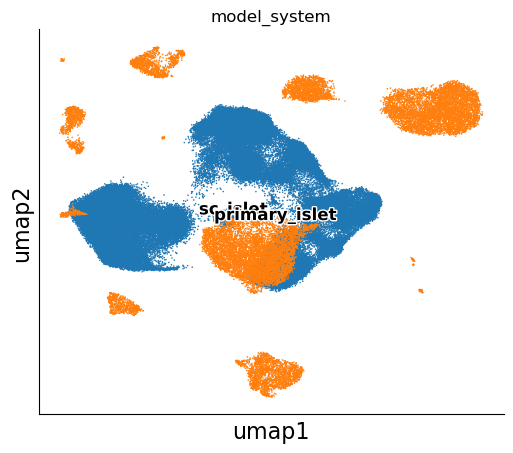

In [54]:
pretty_umap(
    adata,
    color_key="model_system",
    s=5,
)

## Clean up

In [55]:
adata.X = adata.layers["counts"].copy()

In [56]:
del adata.obsm

In [57]:
adata

AnnData object with n_obs × n_vars = 106849 × 36601
    obs: 'gex_barcode_cellranger', 'atac_barcode_cellranger', 'is_cell_cellranger', 'excluded_reason_cellranger', 'gex_raw_reads_cellranger', 'gex_mapped_reads_cellranger', 'gex_conf_intergenic_reads_cellranger', 'gex_conf_exonic_reads_cellranger', 'gex_conf_intronic_reads_cellranger', 'gex_conf_exonic_unique_reads_cellranger', 'gex_conf_exonic_antisense_reads_cellranger', 'gex_conf_exonic_dup_reads_cellranger', 'gex_exonic_umis_cellranger', 'gex_conf_intronic_unique_reads_cellranger', 'gex_conf_intronic_antisense_reads_cellranger', 'gex_conf_intronic_dup_reads_cellranger', 'gex_intronic_umis_cellranger', 'gex_conf_txomic_unique_reads_cellranger', 'gex_umis_count_cellranger', 'gex_genes_count_cellranger', 'atac_raw_reads_cellranger', 'atac_unmapped_reads_cellranger', 'atac_lowmapq_cellranger', 'atac_dup_reads_cellranger', 'atac_chimeric_reads_cellranger', 'atac_mitochondrial_reads_cellranger', 'atac_fragments_cellranger', 'atac_TSS_fr

## Write

In [58]:
adata.write(os.path.join(path_out, "merged.h5ad"))

In [59]:
# Only keep cell types in [SC.alpha, SC.beta, SC.delta, alpha, beta, delta]
adata_filt = adata[adata.obs["celltype"].isin(["SC.alpha", "SC.beta", "SC.delta", "alpha", "beta", "delta"])].copy()
adata_filt.obs["celltype"].value_counts()

SC.alpha    33500
SC.beta     30075
beta         7394
alpha        7207
delta        1162
SC.delta      817
Name: celltype, dtype: int64

In [60]:
# Save
adata_filt.write(os.path.join(path_out, "merged_celltype_filt.h5ad"))

# `atac`

## Load data

In [11]:
path_h5ads = "/cellar/users/aklie/projects/igvf/islet_inflammatory_stress/results/1_sc-islet_integration/merged/atac/merged.h5ads"
path_primary_metadata = "/cellar/users/aklie/data/datasets/islet_10X-Multiome/results/4_integration/atac/annotate/cell_metadata.tsv"
path_sc_metadata = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/results/4_integration/atac/annotate/cell_metadata.tsv"
path_out = "/cellar/users/aklie/projects/igvf/islet_inflammatory_stress/results/1_sc-islet_integration/merged/atac"

In [12]:
adataset = snap.read_dataset(path_h5ads)
adataset

AnnDataSet object with n_obs x n_vars = 164499 x 606219 backed at '/cellar/users/aklie/projects/igvf/islet_inflammatory_stress/results/1_sc-islet_integration/merged/atac/merged.h5ads'
contains 24 AnnData objects with keys: 'HP21167_control', 'pool1_control', 'pool2_control', 'HP21167_cyt', 'HP21197_cyt', 'pool1_cyt', '0-2', '0-3B-1', '15-1', '15-2', 'dm25a', '25-1', 'dm35a', '35-1', 'dm45a', '45-1', 'dm11a', '11-1', 'dm21a', '21-1', 'dm31a', '31-1', '41-1', '41-2'
    obs: 'sample', 'log_n_fragment', 'tsse', 'leiden_1'
    var: 'count', 'selected'
    uns: 'AnnDataSet', 'reference_sequences', 'spectral_eigenvalue'
    obsm: 'X_umap', 'X_spectral'
    obsp: 'distances'

In [13]:
primary_metadata = pd.read_csv(path_primary_metadata, sep="\t", index_col=0)
primary_metadata.head()

,sample,log_n_fragment,tsse,leiden_1,n_fragment,frac_dup,doublet_probability,donor,condition,rna_donor,...,harmony_round_1_leiden_0.8,harmony_round_1_leiden_1.0,harmony_round_1_leiden_1.5,harmony_round_2_leiden_0.2,harmony_round_2_leiden_0.5,harmony_round_2_leiden_0.8,harmony_round_2_leiden_1.0,harmony_round_2_leiden_1.5,harmony_round_2_leiden_2.5,celltype
HP21167_control#AAACAGCCACCTCACC-1,HP21167_control,4.513071,18.233667,9,32588,0.418404,0.057715,HP21167_control,control,HP21167_control,...,5,5,4,1,0,2,1,3,3,alpha
HP21167_control#AAACAGCCATAGACCC-1,HP21167_control,4.268952,22.754011,8,18575,0.419549,0.040001,HP21167_control,control,HP21167_control,...,2,0,0,0,1,0,0,0,1,beta
HP21167_control#AAACAGCCATCCCTCA-1,HP21167_control,4.197336,15.875170,8,15751,0.430796,0.079551,HP21167_control,control,HP21167_control,...,2,0,0,0,1,0,0,7,10,beta
HP21167_control#AAACAGCCATTTAAGC-1,HP21167_control,4.418169,19.580420,9,26191,0.404276,0.042126,HP21167_control,control,HP21167_control,...,5,5,4,1,0,2,1,3,3,alpha
HP21167_control#AAACATGCAGAGGCTA-1,HP21167_control,3.790637,11.624441,7,6174,0.415562,0.052111,HP21167_control,control,HP21167_control,...,8,11,11,5,7,8,8,12,14,activated_stellate


In [14]:
sc_metadata = pd.read_csv(path_sc_metadata, sep="\t", index_col=0)
sc_metadata = sc_metadata[sc_metadata["condition"].isin(["control", "3-cyt"])]
sc_metadata.head()

/tmp/ipykernel_1416517/4053411605.py:1: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  sc_metadata = pd.read_csv(path_sc_metadata, sep="\t", index_col=0)


,sample,log_n_fragment,tsse,leiden_1,sample_id,differentiation_batch,rep,condition,timepoint,cell_line,...,harmony_round_1_leiden_1.5,harmony_round_1_leiden_2.5,assay,harmony_round_2_leiden_0.2,harmony_round_2_leiden_0.5,harmony_round_2_leiden_0.8,harmony_round_2_leiden_1.0,harmony_round_2_leiden_1.5,harmony_round_2_leiden_2.5,celltype
dm11a#AAACAGCCAACAGGTG-1,dm11a,3.044148,12.954545,10,dm11a,DM041,1.0,3-cyt,6,A2,...,13,0,10x_multiome,1,2,2,4,1,10,SC.beta
dm11a#AAACAGCCACACAATT-1,dm11a,4.372967,15.601693,10,dm11a,DM041,1.0,3-cyt,6,A2,...,8,1,10x_multiome,1,5,6,6,2,2,SC.beta
dm11a#AAACAGCCAGCAGGTA-1,dm11a,3.998869,16.723627,10,dm11a,DM041,1.0,3-cyt,6,A2,...,8,1,10x_multiome,1,5,6,6,2,2,SC.beta
dm11a#AAACATGCAAGCCAGA-1,dm11a,3.282849,14.298323,10,dm11a,DM041,1.0,3-cyt,6,A2,...,6,2,10x_multiome,2,3,1,1,5,1,SC.EC
dm11a#AAACATGCACTTACAG-1,dm11a,4.117205,18.423782,10,dm11a,DM041,1.0,3-cyt,6,A2,...,4,14,10x_multiome,0,4,3,3,4,0,SC.alpha


## Create a "donor_id" column so that each "donor_id" has a control and treated sample 
- For SC-islet, `donor_id` will be the timepoint. Here we are assuming that the timepoints for both treatments and differentation batches should not need to any correction (i.e. we are not correcting for condition or differentiation batch, only for donor/timepoint).

In [15]:
# Need to add donor_id column to the stem cells
sc_metadata["donor_id"] = sc_metadata["timepoint"].astype(str)
sc_metadata["donor_id"].value_counts()

48    31714
72    30914
24    26770
6     22176
0     15854
Name: donor_id, dtype: int64

In [16]:
# A
primary_metadata["donor_id"].value_counts()

SAMN22997021    6851
HP21167         4277
HP21197         3009
R413            2258
HP21310         1601
Name: donor_id, dtype: int64

In [17]:
# Double check each donor has control and treated cells
pd.crosstab(primary_metadata["donor_id"], primary_metadata["condition"])

condition,3-cyt,control
donor_id,,
HP21167,3165,1112
HP21197,3009,0
HP21310,594,1007
R413,911,1347
SAMN22997021,935,5916


In [18]:
# Double check each timepoint has control and treated cells
pd.crosstab(sc_metadata["donor_id"], sc_metadata["condition"]).loc[["0", "6", "24", "48", "72"]]

condition,3-cyt,control
donor_id,,
0,0,15854
6,12040,10136
24,13323,13447
48,15710,16004
72,14434,16480


## Use actual samples from 10x for integration
- Here we are assuming that the sample itself contains the technical variation that we want to correct for. This will likely correct for condition, differentiation batch, and donor/timepoint.

In [19]:
# Make a sample_id column
primary_metadata["sample_id"] = primary_metadata["sample"].copy()
primary_metadata["sample_id"].value_counts()

pool2_control      4804
pool1_control      3466
HP21167_cyt        3165
HP21197_cyt        3009
pool1_cyt          2440
HP21167_control    1112
Name: sample_id, dtype: int64

## Concatenate

In [32]:
primary_metadata["model_system"] = "primary_islet"
sc_metadata["model_system"] = "sc_islet"

In [33]:
# Find the ordered intersection of columns
common_cols = []
for i in primary_metadata.columns:
    if i in sc_metadata.columns:
        common_cols.append(i)

In [34]:
metadata = pd.concat([primary_metadata, sc_metadata])[common_cols]
metadata.head()

,sample,log_n_fragment,tsse,leiden_1,n_fragment,frac_dup,condition,rna_harmony_round_2_leiden_1.0,rna_celltype,atac_barcode_cellranger,...,harmony_round_1_leiden_1.5,harmony_round_2_leiden_0.2,harmony_round_2_leiden_0.5,harmony_round_2_leiden_0.8,harmony_round_2_leiden_1.0,harmony_round_2_leiden_1.5,harmony_round_2_leiden_2.5,celltype,sample_id,model_system
HP21167_control#AAACAGCCACCTCACC-1,HP21167_control,4.513071,18.233667,9,32588,0.418404,control,1.0,alpha,ACAGCGGGTATTGTCA-1,...,4,1,0,2,1,3,3,alpha,HP21167_control,primary_islet
HP21167_control#AAACAGCCATAGACCC-1,HP21167_control,4.268952,22.754011,8,18575,0.419549,control,0.0,beta,ACAGCGGGTAAAGGTT-1,...,0,0,1,0,0,0,1,beta,HP21167_control,primary_islet
HP21167_control#AAACAGCCATCCCTCA-1,HP21167_control,4.197336,15.875170,8,15751,0.430796,control,0.0,beta,ACAGCGGGTTAAGTCC-1,...,0,0,1,0,0,7,10,beta,HP21167_control,primary_islet
HP21167_control#AAACAGCCATTTAAGC-1,HP21167_control,4.418169,19.580420,9,26191,0.404276,control,1.0,alpha,ACAGCGGGTTCACTTT-1,...,4,1,0,2,1,3,3,alpha,HP21167_control,primary_islet
HP21167_control#AAACATGCAGAGGCTA-1,HP21167_control,3.790637,11.624441,7,6174,0.415562,control,10.0,activated_stellate,CATTTAGGTAAGTGCA-1,...,11,5,7,8,8,12,14,activated_stellate,HP21167_control,primary_islet


## Subset

In [22]:
# Make output path
subset_out = os.path.join(path_out, "merged_filt.h5ads")
subset_out

'/cellar/users/aklie/projects/igvf/islet_inflammatory_stress/results/1_sc-islet_integration/merged/atac/merged_filt.h5ads'

In [23]:
# Subset to the control and 3-cyt conditions
adataset = adataset.subset(obs_indices=np.where(pd.Index(adataset.obs_names).isin(metadata.index))[0], out=subset_out)[0]
adataset

AnnDataSet object with n_obs x n_vars = 145424 x 606219 backed at '/cellar/users/aklie/projects/igvf/islet_inflammatory_stress/results/1_sc-islet_integration/merged/atac/merged_filt.h5ads/_dataset.h5ads'
contains 24 AnnData objects with keys: 'HP21167_control', 'pool1_control', 'pool2_control', 'HP21167_cyt', 'HP21197_cyt', 'pool1_cyt', '0-2', '0-3B-1', '15-1', '15-2', 'dm25a', '25-1', 'dm35a', '35-1', 'dm45a', '45-1', 'dm11a', '11-1', 'dm21a', '21-1', 'dm31a', '31-1', '41-1', '41-2'
    obs: 'sample', 'log_n_fragment', 'tsse', 'leiden_1'
    var: 'count', 'selected'
    uns: 'spectral_eigenvalue', 'reference_sequences', 'AnnDataSet'
    obsm: 'X_spectral', 'X_umap'
    obsp: 'distances'

In [24]:
adataset.close()

## Add cols

In [25]:
adataset = snap.read_dataset(os.path.join(subset_out, "_dataset.h5ads"))
adataset

AnnDataSet object with n_obs x n_vars = 145424 x 606219 backed at '/cellar/users/aklie/projects/igvf/islet_inflammatory_stress/results/1_sc-islet_integration/merged/atac/merged_filt.h5ads/_dataset.h5ads'
contains 24 AnnData objects with keys: 'HP21167_control', 'pool1_control', 'pool2_control', 'HP21167_cyt', 'HP21197_cyt', 'pool1_cyt', '0-2', '0-3B-1', '15-1', '15-2', 'dm25a', '25-1', 'dm35a', '35-1', 'dm45a', '45-1', 'dm11a', '11-1', 'dm21a', '21-1', 'dm31a', '31-1', '41-1', '41-2'
    obs: 'sample', 'log_n_fragment', 'tsse', 'leiden_1'
    var: 'count', 'selected'
    uns: 'AnnDataSet', 'spectral_eigenvalue', 'reference_sequences'
    obsm: 'X_spectral', 'X_umap'
    obsp: 'distances'

In [37]:
# Columns to add
#cols_to_add = metadata.columns.difference(['sample', 'log_n_fragment', 'tsse', 'leiden_1'])
cols_to_add = ['celltype', 'condition', 'sample_id', 'donor_id']

In [38]:
metadata["model_system"].loc[adataset.obs_names].values.tolist()

['primary_islet',
 'primary_islet',
 'primary_islet',
 'primary_islet',
 'primary_islet',
 'primary_islet',
 'primary_islet',
 'primary_islet',
 'primary_islet',
 'primary_islet',
 'primary_islet',
 'primary_islet',
 'primary_islet',
 'primary_islet',
 'primary_islet',
 'primary_islet',
 'primary_islet',
 'primary_islet',
 'primary_islet',
 'primary_islet',
 'primary_islet',
 'primary_islet',
 'primary_islet',
 'primary_islet',
 'primary_islet',
 'primary_islet',
 'primary_islet',
 'primary_islet',
 'primary_islet',
 'primary_islet',
 'primary_islet',
 'primary_islet',
 'primary_islet',
 'primary_islet',
 'primary_islet',
 'primary_islet',
 'primary_islet',
 'primary_islet',
 'primary_islet',
 'primary_islet',
 'primary_islet',
 'primary_islet',
 'primary_islet',
 'primary_islet',
 'primary_islet',
 'primary_islet',
 'primary_islet',
 'primary_islet',
 'primary_islet',
 'primary_islet',
 'primary_islet',
 'primary_islet',
 'primary_islet',
 'primary_islet',
 'primary_islet',
 'primary_

In [40]:
for col in cols_to_add:
    adataset.obs[col] = metadata[col].values.tolist()

In [41]:
# Close up
adataset.close()

# DONE!

---